## LeNet

LeNet[1] 即 LeNet5，于1988年提出，是最早的卷积神经网络之一。原论文的网络结构是用于训练手写数字的，本节尝试用 LeNet 训练 Fashion MNIST 数据集，因此结构上会有点微调。一共有五层网络（不算输入层），两层卷积层和三层全连接层：

**注** CBAPD 即 **C**onvolutional、**B**atch Normalization、**A**ctivation、**P**ooling、**D**ropout
 + 第一层：卷积层
  + C：使用 6 个 $5\times5$ 的卷积核，步长为 1，不使用全 0 填充（valid）
  + B：不使用批标准化（LeNet 提出时间在 Batch Normalization[2] 提出时间之前）
  + A：使用 sigmoid 激活函数（那个时候是主流的激活函数）
  + P：使用 $2\times2$ 的池化核，采用最大值池化，步长为 2，不使用全 0 填充（valid）
  + D：不使用 Dropout（LeNet 提出时间在 Dropout[3] 提出时间之前）
 + 第二层：卷积层
  + C：使用 16 个 $5\times5$ 的卷积核，步长为 1，不使用全 0 填充（valid）
  + B：不使用批标准化
  + A：使用 sigmoid 激活函数
  + P：使用 $2\times2$ 的池化核，采用最大值池化，步长为 2，不使用全 0 填充（valid）
  + D：不使用 Dropout
 + Flatten 拉伸卷积层传来的输入特征 
 + 第三层：全连接层
  + 120 个神经元
  + 使用 sigmoid 激活函数 
 + 第四层：全连接层
  + 84 个神经元
  + 使用 sigmoid 激活函数
 + 第五层：全连接层（输出层）
  + 10 个神经元
  + 使用 softmax 激活函数

关于 CIFAR-10 数据集的信息可以看上一节。

+ [1] Lecun Y , Bottou L . Gradient-based learning applied to document recognition[J]. Proceedings of the IEEE, 1998, 86(11):2278-2324.
+ [2] Ioffe S , Szegedy C . Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift[J]. 2015.
+ [3] Srivastava N , Hinton G , Krizhevsky A , et al. Dropout: A Simple Way to Prevent Neural Networks from Overfitting[J]. Journal of Machine Learning Research, 2014, 15(1):1929-1958.

In [1]:
import tensorflow as tf
import numpy as np
import os
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

在上一版 baseline 的基础上进行修改

In [2]:
lenet5 = [
    Conv2D(filters=6, kernel_size=5, activation='sigmoid'),
    MaxPool2D(pool_size=2, strides=2),
    Conv2D(filters=16, kernel_size=5, activation='sigmoid'),
    MaxPool2D(pool_size=2, strides=2),
    Flatten(),
    Dense(120, activation='sigmoid'),
    Dense(84, activation='sigmoid'),
    Dense(10, activation='softmax')
]

In [3]:
# 导入数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [4]:
# LeNet5 
model = tf.keras.models.Sequential(lenet5)

In [5]:
# 配置模型参数
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['sparse_categorical_accuracy'])

In [6]:
# 设置断点续训
checkpoint_save_path = './checkpoint/LeNet5.ckpt'
if os.path.exists(checkpoint_save_path + '.index'):
    model.load_weights(checkpoint_save_path)

In [7]:
# 设置保存最优模型参数回调
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_save_path,
                                                save_best_only=True,
                                                save_weights_only=True)

In [8]:
# 训练模型
history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=5,
                    validation_data=(x_test, y_test),
                    validation_freq=1,
                    callbacks=[cp_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 14s 229us/sample - loss: 1.4832 - sparse_categorical_accuracy: 0.4625 - val_loss: 0.8690 - val_sparse_categorical_accuracy: 0.6645
Epoch 2/5
60000/60000 [==============================] - 14s 234us/sample - loss: 0.7337 - sparse_categorical_accuracy: 0.7285 - val_loss: 0.6786 - val_sparse_categorical_accuracy: 0.7443
Epoch 3/5
60000/60000 [==============================] - 14s 234us/sample - loss: 0.6170 - sparse_categorical_accuracy: 0.7598 - val_loss: 0.6003 - val_sparse_categorical_accuracy: 0.7665
Epoch 4/5
60000/60000 [==============================] - 14s 235us/sample - loss: 0.5614 - sparse_categorical_accuracy: 0.7809 - val_loss: 0.5643 - val_sparse_categorical_accuracy: 0.7811
Epoch 5/5
60000/60000 [==============================] - 15s 242us/sample - loss: 0.5190 - sparse_categorical_accuracy: 0.7991 - val_loss: 0.5323 - val_sparse_categorical_accuracy: 0.7884


In [9]:
# 打印网络结构
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  30840     
_________________________________________________________________
dense_1 (Dense)              multiple                  1

In [10]:
np.set_printoptions(threshold=np.inf)
# 保存参数信息
with open('./data/weights.txt', 'w') as file:
    for v in model.trainable_variables:
        file.write(str(v.name) + '\n')
        file.write(str(v.shape) + '\n')
        file.write(str(v.numpy()) + '\n')

In [11]:
# 获取 acc 和 loss 曲线数据
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

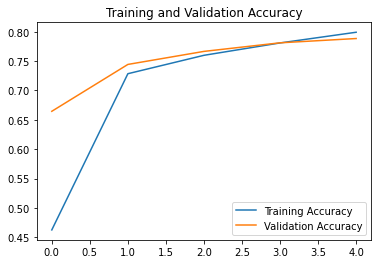

In [12]:
# 可视化 acc 曲线
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

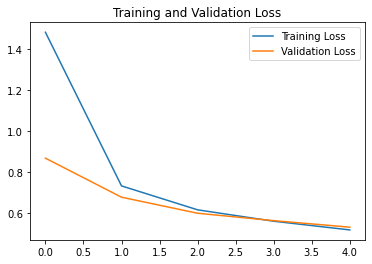

In [13]:
# 可视化 loss 曲线
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()